In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 협업 필터링 구현에 필요한 패키지
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD


###  데이터셋 개요

* 데이터셋: The Movies Dataset
* 데이터셋 개요: 2017년 7월 이전에 개봉한 약 45,000편의 영화들에 대해 제작비, 캐스팅 등 여러
정보(메타데이터)와 함께, 유저가 1~5점 스케일로 작성한 영화에 대한 평가점수 정보를 포함하는 데이터셋입니다.
* 데이터셋 저작권 : CC0 Public Domain


#### 📝 설명 : The Movies Dataset


[Kaggle Dataset page](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data)

2017년 7월
이전 개봉한 45000편의 영화에 대한 메타데이터(캐스팅, 제작비, 수익, 개봉일 등등)와 영화에 대한 평가를
남길수 있는 [MovieLens](https://movielens.org/) 서비스에서 수집된 평점 정보를 수집한
데이터셋입니다.

이 실습에서 사용할 small 버전의 평점 데이터셋은 700명의 유저가 약 9000개의 영화에
대해 작성한 10만건의 평점 데이터로 구성되어 있습니다.

ratings_small.csv & movies_metadata.csv 파일을 다운받아 사용.


# 데이터 전처리

In [23]:
rating_data = pd.read_csv('./data/ratings_small.csv')
movie_data = pd.read_csv('./data/movies_metadata.csv')

C:\Users\jihu6\AppData\Local\Temp\ipykernel_7508\2723773286.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_data = pd.read_csv('./data/movies_metadata.csv')


In [24]:
rating_data.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


timestamp가 매우 큰 정수 형태로 되어 있다는 것을 확인할 수 있다. 이는 기준시점( 1980년 1월 1일 00시 00분)을 기준으로 경과한 시간을 초단위로 나나탠 것.
- 사용하지 않을 정보이기 때문에 제거해도 상관 x

In [25]:
movie_data.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


해당 dataset에서 사용할 정보는id와 title 뿐이니 나머지 정보는 필요 없음

In [26]:
# 영화의 id, title 간 변환을 위한 dict 생성
# 빈 영화 메타데이터의 id에 title을 대응시키는 dict 생성
id_to_title = {row['id']: row['title'] for _, row in movie_data[['id','title']].iterrows()}     
# for _ 에서 _는 특정 값은 필요 없지만 반복 자체는 해야할 때 사용
# iterrows() Pandas DataFrame에서 각 행을 반복하며, 한번에 한 행씩 반환함.
# 반환되는 각 행은 (index,Series) 형태의 튜플임

print(id_to_title['862'])

Toy Story


In [27]:
# 영화의 title에 id를 대응시키는 dict 생성
title_to_id = {v:k for k, v in id_to_title.items()}
# .items() 함수는 id_to_title 이라는 dict안의 key와 value 값들을 tuples형태로 뽑아냄
# v:K 가 앞에 있으니 value가 key가 되고, key가 value 가 된다.
# 이 함수는 많이 쓰일 거 같으니 외워두자.

print(title_to_id['Iron Man'])

194310


In [28]:
# 유저 평점 데이터들 중 동일한 movieId를 가진 sample들을 묶어(groupby) 각 영화에 대한 평점이 몇개인지 확인
movie_rating_count = rating_data.groupby('movieId')['rating'].count()
# rating_data 데이터프레임을 movieId 열을 기준으로 그룹화합니다.
# 동일한 movieId 값을 가진 행끼리 하나의 그룹으로 묶습니다.
# [rating] 그룹화된 데이터 중에서 rating 열만 선택
# .count() 각 그룹에서 rating 열의 값 개수를 count 해줌.

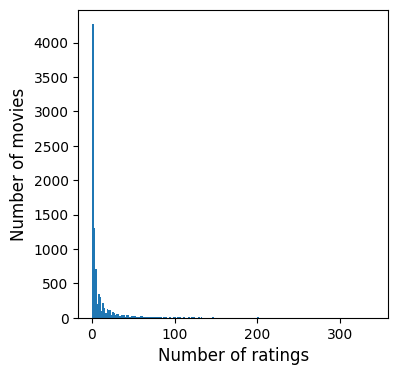

In [29]:
# 히스토그램 시각화
plt.figure(figsize=(4,4))
fig = plt.hist(movie_rating_count, bins=200) # 데이터를 구간(bin=200개)별로 나누고, 각 구간에 해당하는 데이터 개수를 시각화하는 히스토 그램 생성
plt.xlabel('Number of ratings', fontsize=12)
plt.ylabel('Number of movies', fontsize=12)
plt.show()

In [30]:
print("평점 데이터 내에 있는 총 영화 수 : ", len(rating_data['movieId'].unique()))
#.unique() 함수는 특정 열에서 중복되지 않은 고유한 값을 추출해준다. (pandas 함수)

print("10개 이상의 평점을 받은 영화 수 : ", len(movie_rating_count[movie_rating_count >= 10]))

print("100개 이상의 평점을 받은 영화 수 : ", len(movie_rating_count[movie_rating_count >= 100]))

평점 데이터 내에 있는 총 영화 수 :  9066
10개 이상의 평점을 받은 영화 수 :  2245
100개 이상의 평점을 받은 영화 수 :  151


In [31]:
# 영화별 평균 평점의 분포 확인
# (영화별 받은 평가의 수 / 평균 점수)를 각각 첫번째, 두번째 column으로 하는 데이터 생성
movie_rating_info = rating_data.groupby("movieId")['rating'].agg(['count', 'mean'])
# .agg 함수는 다양한 연산을 한번에 수행할수 있도록 지원하는 함수 (pandas library)

# movie_rating_info의 columns 이름 설정
movie_rating_info.columns = ['rated_count', 'rating_mean']

movie_rating_info


,rated_count,rating_mean
movieId,,
1,247,3.872470
2,107,3.401869
3,59,3.161017
4,13,2.384615
5,56,3.267857
...,...,...
161944,1,5.000000
162376,1,4.500000
162542,1,5.000000


<Axes: >

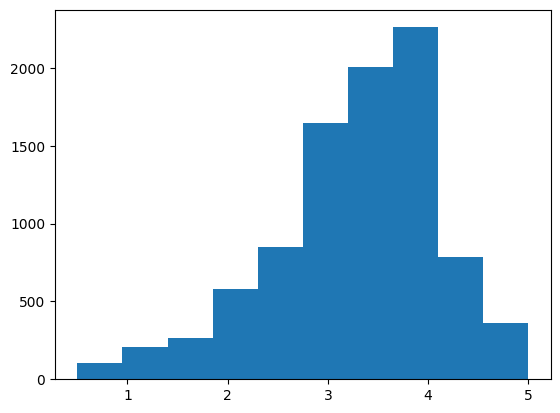

In [32]:
# 영화별 평가점수 분포 확인
movie_rating_info['rating_mean'].hist(grid=False)
# hist = histogram 생성 함수 grid = 배경 격자

In [33]:
# 충분한 평가(100개 이상)를 받은 영화들 중 평균 평점이 높은 영화들의 id를 확인
# 확인한 고평점 영화 id에 해당하는 영화 제목을 확인해 출력

# 100번 이상의 평가를 받은 영화중, 평점이 높은 10개의 영화 출력
indices_enough_eval = movie_rating_info['rated_count'] > 100
# 평가수(rated_count)가 100 이상인 영화들만 추려냄

# 평가수 100개 이상인 영화들만 선택 후 최고 평점인 10개 영화의 id확인
top_10_movies = movie_rating_info[indices_enough_eval].nlargest(10,'rating_mean')
# .nlargest 함수 'rating_mean'열에서 가장 큰 값을 가진 10개를 추려내겠다

top_10_movies

,rated_count,rating_mean
movieId,,
858,200,4.487500
318,311,4.487138
1221,135,4.385185
50,201,4.370647
527,244,4.303279
1193,144,4.256944
608,224,4.256696
296,324,4.256173
2858,220,4.236364


In [34]:
for movie_id, (count, score) in top_10_movies.iterrows():
# .iterrows 함수: 행을 하나씩 순차적으로 처리할 때 사용되는 함수
    try: # 예외가 발생할 가능성이 있는 코드
        #영화 메타데이터 내에 해당 id의 영화가 있다면 타이틀을 출력
        title = id_to_title[str(movie_id)]
    except KeyError: #예외 발생시 처리할 코드 (KeyError면 없는 값을 검색했을 때 나오는 에러일 거임)
        # 영화 타이틀이 없다면 영화 id를 그대로 출력 
        title = f'unknown movie id: {movie_id}'

    # 제목과 받은 평점. 평가 수를 함께 출력
    print(f'{title},score:{score:.03}, count: {int(count)}')


Sleepless in Seattle,score:4.49, count: 200
The Million Dollar Hotel,score:4.49, count: 311
unknown movie id: 1221,score:4.39, count: 135
unknown movie id: 50,score:4.37, count: 201
Once Were Warriors,score:4.3, count: 244
unknown movie id: 1193,score:4.26, count: 144
Men in Black II,score:4.26, count: 224
Terminator 3: Rise of the Machines,score:4.26, count: 324
unknown movie id: 2858,score:4.24, count: 220
Confession of a Child of the Century,score:4.24, count: 121


## 메모리 기방의 협업 필터링

In [35]:
rating_data

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [36]:
# 불필요한 timestamp 제거
rating_data.drop('timestamp', axis=1, inplace=True)
# inplace = True는 원본 DataFrame을 수정해 삭제후 결과를 새로운 변수에 할당할 필요 없이 직접적으로 변경함

# 유저-아이템 선호도 행렬을 생성
user_movie_rating = rating_data.pivot_table('rating', index='userId', columns='movieId')

# 평가 없는 빈 값들 0으로 채우기
user_movie_rating.fillna(0,inplace=True)

print(user_movie_rating)


movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           0.0     0.0     4.0     0.0     0.0     0.0     0.0     0.0   
...         ...     ...     ...     ...     ...     ...     ...     ...   
667         0.0     0.0     0.0     0.0     0.0     4.0     0.0     0.0   
668         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
669         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
670         4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
671         5.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  9       10     

위에서 생성한 유저-아이템 선호도 행렬은 대부분 값이 0으로 비어있다. 이런 형태의 행렬을 "희소행렬"이라고 부른다.

0인 부분은 생략하고 나머지 부분의 데이터만 저장해 효율적으로 메모리를 사용하는 CSR, COO 등의 여러 효율적인 데이터 포멧을 사용할 수 있고, 연산시에도 이런 포멧에 최적화된 여러 연산들을 사용하면 효율적이다.

In [38]:
user_ratings_matrix_T = user_movie_rating.transpose()
# transpose 함수 = 행과 열을 바꾸는 함수

# 모든 아이템(영화) 쌍마다 코사인유사도를 계산해 행렬의 형태로 저장
item_sim = cosine_similarity(user_ratings_matrix_T,user_ratings_matrix_T)

# 생성된 유사도 행렬에 원래의 movie id 정보를 추가해 다시 dataframe 형태로 변환
movie_ids = user_movie_rating.columns
item_sim_df = pd.DataFrame(
    data = item_sim,
    index=movie_ids,
    columns=movie_ids
)

# 생성된 유사도 행렬 확인
print(item_sim_df.shape, item_sim_df.head(5))

(9066, 9066) movieId    1         2         3         4         5         6         7       \
movieId                                                                         
1        1.000000  0.394511  0.306516  0.133614  0.245102  0.377086  0.278629   
2        0.394511  1.000000  0.217492  0.164651  0.278476  0.222003  0.207299   
3        0.306516  0.217492  1.000000  0.177012  0.370732  0.247499  0.435648   
4        0.133614  0.164651  0.177012  1.000000  0.179556  0.072518  0.184626   
5        0.245102  0.278476  0.370732  0.179556  1.000000  0.272645  0.388476   

movieId    8         9         10      ...    161084    161155    161594  \
movieId                                ...                                 
1        0.063031  0.117499  0.310689  ...  0.055829  0.031902  0.079755   
2        0.223524  0.113669  0.418124  ...  0.000000  0.055038  0.068797   
3        0.127574  0.306717  0.191255  ...  0.000000  0.000000  0.000000   
4        0.501513  0.254630  0.111447  

## 특정 영화와 가장 비슷한 영화 목록 찾기

In [39]:
# 직접 영화 제목을 지정하는 경우
movie_title = "Men in Black II"
target_movie_id = int(title_to_id[movie_title])

# # 랜덤으로 선택하는 경우
# available_ids = [movie_id for movie_id in rating_data['movieId'].unique() if str(movie_id) in id_to_title]
# target_movie_id = np.random.choice(available_ids)
# movie_title = id_to_title[str(target_movie_id)]

# 선택된 영화의 제목과 id를 출력
print("분석대상 영화 : ", movie_title)
print("id : ", target_movie_id)

# 자기자신을 제외하고 가장 비슷한 5개의 영화 아이다를 찾기
result = item_sim_df[target_movie_id].sort_values(ascending=False)[1:6]
# sort_values()는 데이터의 값을 오름차순 또는 내림차순으로 정렬하는 함수입니다.
# ascending=False로 설정하면, 유사도 값이 큰 것부터 작은 순서로 내림차순 정렬됩니다. 즉, target_movie_id와 가장 유사한 영화가 먼저 오게 됩니다.
# [1:6]은 첫 번째 영화는 제외하고 두 번째에서 여섯 번째까지의 영화를 선택하는 것입니다. (유사도는 첫 번째가 자기 자신이기 때문에 이를 제외하고 가장 유사한 영화들을 선택)

print("\n이 영화와 유사한 영화들 : ")
for movie_id, similarity in result.items():
    try: # 영화 메타데이터 내에 해당 id의 영화가 있다면 타이틀을 출력
        title = id_to_title[str(movie_id)]
    except KeyError:
        # 없다면 영화 id를 그대로 출력
        title = f'unknown movie id: {movie_id}'

    print(f"{title}, 유사도 : {similarity:.03}")


분석대상 영화 :  Men in Black II
id :  608

이 영화와 유사한 영화들 : 
Terminator 3: Rise of the Machines, 유사도 : 0.583
unknown movie id: 36, 유사도 : 0.543
unknown movie id: 50, 유사도 : 0.542
The Talented Mr. Ripley, 유사도 : 0.537
Point Break, 유사도 : 0.537


In [40]:
# 모든 유저 쌍마다 코사인유사도를 계산해 행렬의 형태로 저장
item_sim = cosine_similarity(user_movie_rating, user_movie_rating)

# 생성된 유사도 행렬에 원래의 movie id정보를 추가해 다시 dataframe형태로 변환
movie_ids = user_movie_rating.index
item_sim_df = pd.DataFrame(
    data=item_sim,
    index=movie_ids,
    columns=movie_ids
)

# 생성된 유사도 행렬 확인
print(item_sim_df.shape)
item_sim_df.head()

(671, 671)


userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.074482,0.016818,0.000000,0.083884,0.000000,0.012843,0.000000,...,0.000000,0.000000,0.014474,0.043719,0.000000,0.000000,0.000000,0.062917,0.000000,0.017466
2,0.000000,1.000000,0.124295,0.118821,0.103646,0.000000,0.212985,0.113190,0.113333,0.043213,...,0.477306,0.063202,0.077745,0.164162,0.466281,0.425462,0.084646,0.024140,0.170595,0.113175
3,0.000000,0.124295,1.000000,0.081640,0.151531,0.060691,0.154714,0.249781,0.134475,0.114672,...,0.161205,0.064198,0.176134,0.158357,0.177098,0.124562,0.124911,0.080984,0.136606,0.170193
4,0.074482,0.118821,0.081640,1.000000,0.130649,0.079648,0.319745,0.191013,0.030417,0.137186,...,0.114319,0.047228,0.136579,0.254030,0.121905,0.088735,0.068483,0.104309,0.054512,0.211609
5,0.016818,0.103646,0.151531,0.130649,1.000000,0.063796,0.095888,0.165712,0.086616,0.032370,...,0.191029,0.021142,0.146173,0.224245,0.139721,0.058252,0.042926,0.038358,0.062642,0.225086


## SVD 행렬분해 / 이를 활용한 평점 예측

In [41]:
user_movie_rating

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# 전체 데이터의 평균을 구하고 결과를 출력
total_avg_rating = user_movie_rating.to_numpy().mean()
print(total_avg_rating)

# 이를 이용해 전체 평점 데이터의 평균을 0으로 맞추는 전저리를 진행
centered_user_movie_rating = user_movie_rating - total_avg_rating
centered_user_movie_rating

0.05825387792058437


movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,...,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254
2,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,3.941746,...,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254
3,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,...,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254
4,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,3.941746,...,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254
5,-0.058254,-0.058254,3.941746,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,...,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,3.941746,-0.058254,-0.058254,-0.058254,-0.058254,...,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254
668,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,...,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254
669,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,...,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254


svds 함수를 사용해 유저-아이템 행렬에 Truncated SVD 적용  
분해된 결과 행렬들을 다시 곱해, 원래의 유저-아이템 행렬을 불완전하게 복원하는 방식으로 원래 0이었던 빈 값들을 채워 넣음

In [43]:
# truncated svd 수행. 원본 행렬을 12개의 rank-1 행렬의 합으로 표현
U, sigma, Vt = svds(centered_user_movie_rating.to_numpy(), k=12)

# 원래의 유저-아이템 행렬을 불완전하게 복원
svd_user_predicted_ratings = (U * sigma) @ Vt + total_avg_rating

# 결과를 다시 dataframe으로 변환 후 값을 확인
df_svd_preds = pd.DataFrame(svd_user_predicted_ratings, columns=centered_user_movie_rating.columns)
df_svd_preds

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,0.146740,0.004646,0.049713,0.054292,-0.004071,0.015801,0.004645,0.036489,0.052664,0.050779,...,0.028092,0.046956,0.038585,0.046779,0.045968,0.046071,0.033676,0.049428,0.049017,0.007783
1,1.189027,1.659180,0.450501,0.156798,0.452162,0.985345,0.427193,0.098561,0.249223,2.120925,...,0.011784,0.002389,0.019385,0.003128,0.002071,-0.021267,0.026457,0.005592,0.005452,0.018326
2,1.022856,0.384058,0.051160,0.028460,0.064683,0.159346,-0.044248,0.030955,0.002234,0.385856,...,0.002554,0.005697,-0.018730,0.000253,-0.005254,-0.004565,-0.033728,0.017292,0.014883,-0.006160
3,2.006487,1.155363,0.369163,0.109473,-0.079195,-0.481780,0.008802,-0.142077,0.045500,1.518102,...,0.031354,-0.013313,0.039339,0.036432,0.055589,-0.020589,0.059950,-0.004755,-0.003605,0.064589
4,1.406690,0.897871,0.151010,0.117464,0.644111,-0.220477,0.324445,0.114115,-0.037225,0.580117,...,-0.000918,0.019773,0.019976,0.024903,0.024898,-0.006761,0.017508,0.027834,0.026666,-0.026750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,1.635128,1.006568,0.697195,0.171630,0.611667,1.525167,0.695749,0.045398,0.383905,1.318320,...,0.009321,0.013747,0.008693,0.001641,-0.001271,0.014667,0.009307,0.006698,0.007005,0.011177
667,0.572921,-0.011752,0.092316,0.053868,0.027016,0.270599,-0.039194,0.018991,0.051330,0.028059,...,0.010731,0.025282,0.009215,0.021336,0.018740,0.010932,0.000559,0.028593,0.027767,-0.005067
668,0.637262,-0.038286,0.170125,0.062326,0.132391,0.104950,0.073271,0.020593,0.080281,-0.103084,...,0.022755,0.035396,0.017144,0.034446,0.033424,0.032190,0.007470,0.038427,0.037653,0.009020
669,1.292342,0.220911,0.323993,0.073913,0.263481,0.717831,0.224178,0.023232,0.155429,0.298560,...,0.006037,0.009378,-0.023811,0.000405,-0.003784,0.005308,-0.040108,0.012639,0.011096,0.003292


#### 해당 코드는 패스트 캠퍼스 교육자료에 나온 코드를 해석한 것입니다.